In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

In [3]:
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

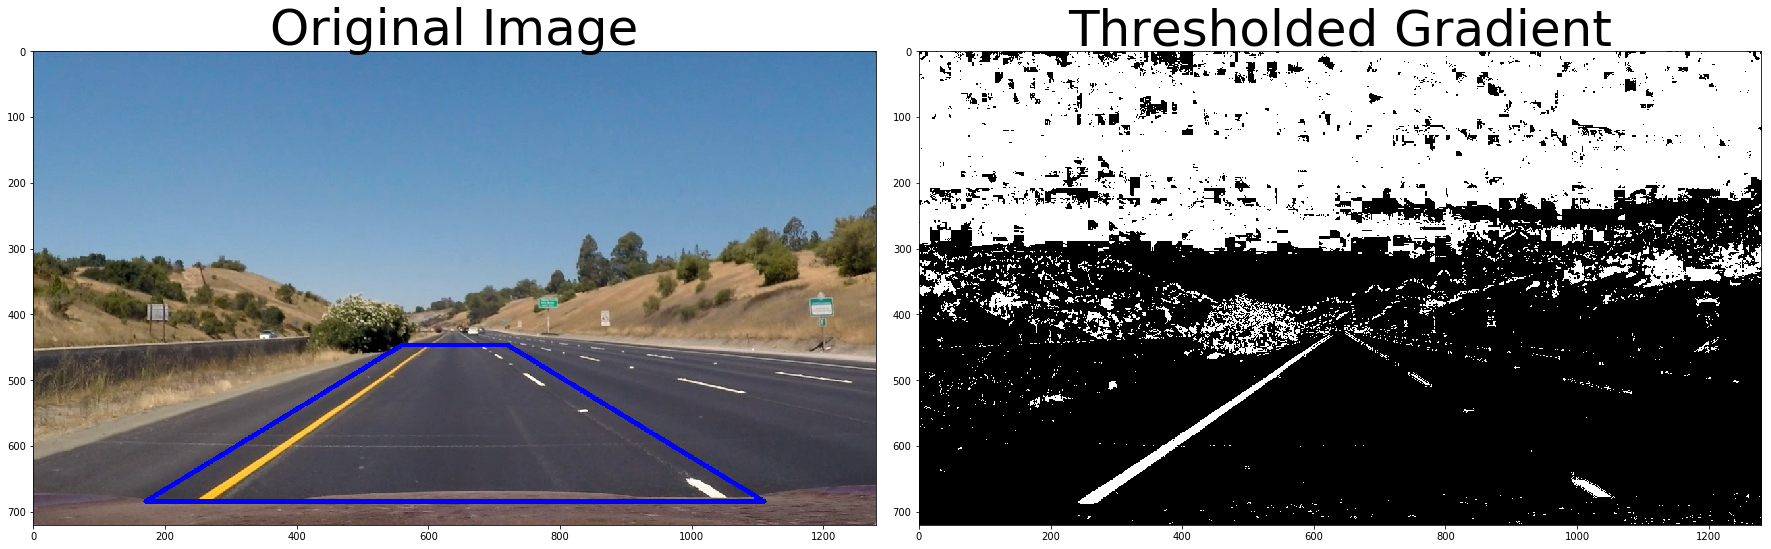

In [4]:
#Define Sobelx, sobely, magnitude, direction and color

# Read in an image and grayscale it
image = mpimg.imread('./test_images/straight_lines1.jpg')

def abs_sobel_thresh_x(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sx=cv2.Sobel(gray,cv2.CV_64F,1,0)
    # 3) Take the absolute value of the derivative or gradient
    abs=np.absolute(sx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled=(255*abs)/np.max(abs)
    scaled=np.uint8(scaled)
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary=np.zeros_like(scaled)
    sxbinary[(scaled>thresh_min) & (scaled<thresh_max)] = 1
    # 6) Return this mask as your binary_output image
     
    return sxbinary

def abs_sobel_thresh_y(img, orient='y', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sy=cv2.Sobel(gray,cv2.CV_64F,0,1)
    # 3) Take the absolute value of the derivative or gradient
    abs=np.absolute(sy)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled=(255*abs)/np.max(abs)
    scaled=np.uint8(scaled)
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sybinary=np.zeros_like(scaled)
    sybinary[(scaled>thresh_min) & (scaled<thresh_max)] = 1
    # 6) Return this mask as your binary_output image
     
    return sybinary
    
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy=np.sqrt(np.square(sobelx)+np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled=np.uint8((255*abs_sobelxy)/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary=np.zeros_like(scaled)
    binary[(scaled>mag_thresh[0]) & (scaled<mag_thresh[1])]=1
    # 6) Return this mask as your binary_output image
   
    return binary
    
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx=cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_x=np.absolute(sobelx)
    abs_y=np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction=np.arctan2(abs_y,abs_x)
    # 5) Create a binary mask where direction thresholds are met
    binary_output=np.zeros_like(direction)
    binary_output[(direction>thresh[0]) & (direction<thresh[1])]=1
    # 6) Return this mask as your binary_output image
    return binary_output

def color_binary(img, color_thresh=(0,255)):
    hls=cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]

    s_binary=np.zeros_like(s_channel)
    s_binary[(s_channel>=color_thresh[0])&(s_channel<=color_thresh[1])]=1
    
    return s_binary

# Run the Sobelx
gradx = abs_sobel_thresh_x(image, orient='x', thresh_min=25, thresh_max=255)
# Run the Sobely
grady = abs_sobel_thresh_y(image, orient='y', thresh_min=30, thresh_max=125)
# Run the Magnitude
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 150))
# Run the Direction
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(.7, 1.2))
# Run the Color
s_binary=color_binary(image,color_thresh=(100,255))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1

##Show lines to define source points
show_lines=True
if(show_lines):
    img_shp=image.shape
    mask_y_height=int(img_shp[0]*0.62)
    
    center_x = img_shp[1]//2
    upper_margin_left = 80
    lower_margin_left = 470
    upper_margin_right = 80
    lower_margin_right = 470
    left_up_margin=center_x - upper_margin_left
    right_up_margin=center_x + upper_margin_right
    left_down_margin=center_x - lower_margin_left
    right_down_margin=center_x + lower_margin_right
    
    cv2.line(image,(int(left_down_margin),int(img_shp[0]*0.95)),(int(left_up_margin),mask_y_height),(0,0,255),5)
    cv2.line(image,(int(left_up_margin),mask_y_height),(int(right_up_margin),mask_y_height),(0,0,255),5)
    cv2.line(image,(int(right_up_margin),mask_y_height),(int(right_down_margin),int(img_shp[0]*0.95)),(0,0,255),5) 
    cv2.line(image,(int(left_down_margin),int(img_shp[0]*0.95)),(right_down_margin,int(img_shp[0]*0.95)),(0,0,255),5)             
        
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plt.show()

In [5]:
def warp_the_image(img,save_images=False,plot_result=False,idx=0):
    ## Warp Road Images
  
    img_shp=img.shape
    mask_y_height = int(img_shp[0]*0.62) #Upper bound of y
    offset=img.shape[0]*0.25 #Offset
    img_size=(img.shape[1],img.shape[0])

    # Undistort images
    img=cv2.undistort(img, mtx, dist, None, mtx)
    
    # Run the Sobelx
    gradx = abs_sobel_thresh_x(img, orient='x', thresh_min=25, thresh_max=255)
    # Run the Sobely
    grady = abs_sobel_thresh_y(img, orient='y', thresh_min=30, thresh_max=125)
    # Run the Magnitude
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 150))
    # Run the Direction
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(.7, 1.2))
    # Run the Color
    s_binary=color_binary(img,color_thresh=(100,255))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
    
    # Find source and destination points
    center_x = img_shp[1]
    top_width = .075  
    lower_width = 0.72
    #print(0.5-top_width/2)
    #print(0.5-lower_margin_left/2)
    left_up_margin=(center_x) * (0.5-top_width/2)
    right_up_margin=(center_x) * (0.5+top_width/2)
    left_down_margin=(center_x) * (0.5-lower_width/2)
    right_down_margin=(center_x) * (0.5+lower_width/2)
    
    upper_right=(right_up_margin,mask_y_height)
    lower_right=(right_down_margin,img_shp[0]*0.95)
    lower_left=(left_down_margin,img_shp[0]*0.95)
    upper_left=(left_up_margin,mask_y_height)

    #Source Points taken from approximate lines on image
    src=np.float32([upper_left,
                    upper_right,
                    lower_right,
                    lower_left])

    dst=np.float32([[offset,0],
                    [img_size[0]-offset,0],
                    [img_size[0]-offset,img_size[1]],
                    [offset,img_size[1]]])
   
    M = cv2.getPerspectiveTransform(src, dst)
    Minv=cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)*255
  
   
    if(save_images):
        cv2.imwrite('output_images/warped_combined'+str(idx)+'.jpg',warped)    
    
    if(plot_result):
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(warped,cmap='gray')
        ax2.set_title('Warped Lane Image'+str(idx), fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

        plt.show()
        
    return warped,M,Minv

In [6]:
##Histogram, slice into windows, polyfit, fillpoly
left_fit_list=[]
right_fit_list=[]

def draw_polyfit(binary_warped,draw_polyfit_lines=False):

    binary_warped,_,_=warp_the_image(binary_warped)
    #binary_warped=cv2.cvtColor(binary_warped,cv2.COLOR_RGB2GRAY)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//3:,:], axis=0)
    #plt.plot(histogram) 
    #plt.show()     
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        #Closer to top
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        #Closer to bottom
        win_y_high = binary_warped.shape[0] - window*window_height
        #left mid according to histogram - margin
        win_xleft_low = leftx_current - margin
        #left mid according to histogram + margin
        win_xleft_high = leftx_current + margin
        #right mid according to histogram - margin
        win_xright_low = rightx_current - margin
        #right mid according to histogram + margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        # left low, right high points
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 1) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 1) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        #print("good left ind: {0}".format(good_left_inds))
        #print("good right ind: {0}".format(good_right_inds))
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
       
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))    
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))     
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_fit_list.append((left_fit[0],left_fit[1],left_fit[2]))
    right_fit_list.append((right_fit[0],right_fit[1],right_fit[2]))
      
    ratio=0.6
    if(len(left_fit_list)>3):
        left_fit[0] = left_fit_list[-3][0]*(1-ratio)/2+left_fit_list[-2][0]*(1-ratio)/2+left_fit_list[-1][0]*ratio
        left_fit[1] = left_fit_list[-3][1]*(1-ratio)/2+left_fit_list[-2][1]*(1-ratio)/2+left_fit_list[-1][1]*ratio
        left_fit[2] = left_fit_list[-3][2]*(1-ratio)/2+left_fit_list[-2][2]*(1-ratio)/2+left_fit_list[-1][2]*ratio
                       
    if(len(right_fit_list)>3):
        right_fit[0] = right_fit_list[-3][0]*(1-ratio)/2+right_fit_list[-2][0]*(1-ratio)/2+right_fit_list[-1][0]*ratio
        right_fit[1] = right_fit_list[-3][1]*(1-ratio)/2+right_fit_list[-2][1]*(1-ratio)/2+right_fit_list[-1][1]*ratio
        right_fit[2] = right_fit_list[-3][2]*(1-ratio)/2+right_fit_list[-2][2]*(1-ratio)/2+right_fit_list[-1][2]*ratio
                      
   
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    #leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    #rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print("left curve rad:{0} right curve rad:{1}".format(left_curverad, right_curverad)) 
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
   
    
    if(draw_polyfit_lines):
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    
    return out_img,ploty,left_fitx,right_fitx,left_curverad,right_curverad

In [7]:
# Create an image to draw the lines on
def lane_area(image):
    #orj_img=mpimg.imread('./test_images/test2.jpg')
    binary_warped,M,Minv= warp_the_image(image)
    _,ploty,left_fitx,right_fitx,left_curverad,right_curverad=draw_polyfit(image,draw_polyfit_lines=False)
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    curve=(left_curverad+right_curverad)/2
    cv2.putText(image,'Left R: '+str(round(left_curverad))+' m',(10,30), font, 1,(255,127,80),2,cv2.LINE_AA)
    cv2.putText(image,'Right R: '+str(round(right_curverad))+' m',(10,30+30), font, 1,(255,127,80),2,cv2.LINE_AA)
    
    center_fitx=(left_fitx+right_fitx)//2
    center_image = binary_warped.shape[1]//2
    xm_per_pix = 3.7/900    
    
    if (center_fitx[-1]-center_image)>0:
        #print('right position: {}'.format(center_fitx[-1]-center_image))
        cv2.putText(image,'Car at left side: '+str(round((center_fitx[-1]-center_image)*xm_per_pix*100))+' cm',(10,60+30), font, 1,(255,127,80),2,cv2.LINE_AA)
    elif(center_fitx[-1]-center_image)<0:
        #print('left position: {}'.format(center_image-center_fitx[-1]))
        cv2.putText(image,'Car at right side: '+str(round((center_image-center_fitx[-1])*xm_per_pix*100))+' cm',(10,60+30), font, 1,(255,127,80),2,cv2.LINE_AA)
    else:
        cv2.putText(image,'Car at center',(10,60+30), font, 1,(255,127,80),2,cv2.LINE_AA)
        
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    #plt.show()
    return result

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
output='./output_images/video1.mp4'

clip=VideoFileClip('project_video.mp4')#.subclip(39,44)
warped_clip=clip.fl_image(lane_area)
%time warped_clip.write_videofile(output,audio=False)

[MoviePy] >>>> Building video ./output_images/video1.mp4
[MoviePy] Writing video ./output_images/video1.mp4



  0%|                                                 | 0/1261 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))
